# GPT-2 Language Model 

**Objective:** Deploy a pre-trained **GPT-2** Language Model using Hugging Face, explore its capabilities via **text continuation, story generation, and Q&A-style completion**, and visualize key behaviors with **matplotlib**.

---

### Why GPT-2?
- GPT-2 is a **decoder-only Transformer** trained for **autoregressive** language modeling.  
- It excels at **creative text generation** and demonstrates how modern LMs **extend context** token by token.  
- Hugging Face makes it **simple to implement**, enabling us to focus on **analysis, visualization, and ethics** rather than boilerplate.

## Learning Outcomes

1. Load and run a **pre-trained GPT-2** model from Hugging Face.
2. Generate text for **three scenarios**: text continuation, story, and Q&A.
3. Visualize:
   - **Next-token probability distribution** (what the model thinks *next*).
   - **Self-attention heatmap** (how tokens attend to previous tokens).
4. Quantitatively analyze outputs using simple **diversity** metrics.
5. Frame **research questions**, discuss **limitations**, and present **ethical considerations**.

In [3]:
!pip install transformers torch matplotlib --quiet

import math
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)

PyTorch version: 2.8.0+cpu


## Load GPT-2 (Pre-trained)
We will load the **tokenizer** and **model** for GPT-2.  
The **pipeline** API gives us a high-level interface for quick generation demos.

In [26]:
!pip install ipywidgets

MODEL_NAME = "gpt2"  # You may switch to 'gpt2-medium' if you have more compute

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto" if torch.cuda.is_available() else None)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"Loaded {MODEL_NAME} on {device}.")

Defaulting to user installation because normal site-packages is not writeable


Device set to use cpu


Loaded gpt2 on cpu.


## Helper Functions
We define utilities for generation, token-probability visualization, attention heatmaps, and diversity metrics.

In [42]:
def generate_text(prompt, max_new_tokens=80, temperature=0.8, top_p=0.9, top_k=50, num_return_sequences=1, do_sample=True, stop_seq="Q:"):
    outputs = generator(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_return_sequences=num_return_sequences,
        do_sample=do_sample,
        pad_token_id=tokenizer.eos_token_id,
    )

    results = []
    for o in outputs:
        full_text = o["generated_text"]
        completion = full_text[len(prompt):]
        if stop_seq in completion:
            completion = completion.split(stop_seq)[0]
        results.append(completion.strip())
    return results

def plot_topk_next_token_probs(prompt, top_k=15):
    # Tokenize input and compute next-token distribution
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    logits = out.logits[:, -1, :]  # last token logits
    probs = torch.softmax(logits, dim=-1).squeeze(0)

    # Get top-k token ids and probs
    top_probs, top_ids = torch.topk(probs, k=top_k)
    top_tokens = [tokenizer.decode([idx]) for idx in top_ids.tolist()]
    top_vals = top_probs.cpu().numpy()

    # Plot (single chart, default colors, no seaborn)
    plt.figure(figsize=(10, 4))
    plt.bar(range(top_k), top_vals)
    plt.xticks(range(top_k), top_tokens, rotation=45, ha="right")
    plt.title("Top-k Next Token Probabilities")
    plt.ylabel("Probability")
    plt.xlabel("Token")
    plt.tight_layout()
    plt.show()


def attention_heatmap(prompt, layer_index=-1, head_agg="mean"):
    """Visualize a self-attention heatmap for the given prompt.
    - layer_index: which layer to visualize (-1 = last layer)
    - head_agg: 'mean' to average across heads
    """
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    # attentions: tuple(num_layers) each [batch, heads, seq_len, seq_len]
    attn = outputs.attentions[layer_index].squeeze(0)  # [heads, seq_len, seq_len]

    if head_agg == "mean":
        attn_matrix = attn.mean(dim=0).cpu().numpy()  # [seq_len, seq_len]
    else:
        attn_matrix = attn[0].cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Heatmap (single chart, default colormap)
    plt.figure(figsize=(6, 6))
    plt.imshow(attn_matrix, aspect="auto")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.title("Self-Attention Heatmap (Averaged Heads)")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.tight_layout()
    plt.show()


def distinct_n(text, n=2):
    tokens = text.split()
    if len(tokens) < n:
        return 0.0
    ngrams = set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))
    return len(ngrams) / (len(tokens) - n + 1)


def repetition_ratio(text, window=5):
    tokens = text.split()
    if len(tokens) <= window:
        return 0.0
    repeats = 0
    total = 0
    for i in range(len(tokens) - window):
        a = tokens[i:i+window]
        b = tokens[i+1:i+1+window]
        total += 1
        if a == b:
            repeats += 1
    return repeats / total if total > 0 else 0.0

#### Quick Smoke Test

In [29]:
sample = generate_text("Once upon a time", max_new_tokens=30)[0]
print(sample)

it was seen as a common law thing to marry, and the women of England had already been quite comfortable with this practice, so there was no objection


## Experiment 1 — Text Continuation
We analyze how GPT-2 continues a partial sentence with varying **temperature** and **top-p**.

In [9]:
prompt_cont = "In the rapidly evolving field of artificial intelligence, researchers have discovered that"
variants = [
    {"temperature": 0.7, "top_p": 0.9},
    {"temperature": 1.0, "top_p": 0.95},
    {"temperature": 1.3, "top_p": 0.92},
]

for i, cfg in enumerate(variants, 1):
    print(f"\n--- Variant {i}: temperature={cfg['temperature']}, top_p={cfg['top_p']} ---")
    out = generate_text(prompt_cont, max_new_tokens=80, temperature=cfg["temperature"], top_p=cfg["top_p"])[0]
    print(out)


--- Variant 1: temperature=0.7, top_p=0.9 ---
In the rapidly evolving field of artificial intelligence, researchers have discovered that the human brain is often unable to recognize that it has an automatic understanding of what it is doing.

The finding is a significant step forward in understanding the human brain, said William Shatner, a neuroscientist at the University of California, Berkeley.

"The human brain is a very complex machine," Shatner said. "It has complex, nuanced, and complex human

--- Variant 2: temperature=1.0, top_p=0.95 ---
In the rapidly evolving field of artificial intelligence, researchers have discovered that the human brain can be used as a human brain.

"We just started on [the] human brain project because they used the same basic concept and had such a lot of success," said James McManus, a professor of computer science at the Georgia Institute of Technology and the study's lead author. "That's kind of amazing what we saw."

Researchers are also working o

## Experiment 2 — Story Generation
We give a creative prompt and let the model produce a short story.

In [10]:
prompt_story = "Write a short story set in Bengaluru about a student who builds an AI that helps local vendors:"
story = generate_text(prompt_story, max_new_tokens=180, temperature=0.95, top_p=0.95)[0]
print(story)
print("\nDistinct-1:", distinct_n(story, n=1))
print("Distinct-2:", distinct_n(story, n=2))
print("Repetition ratio:", repetition_ratio(story))

Write a short story set in Bengaluru about a student who builds an AI that helps local vendors:

Read a story about a Bengaluru-based startup that works with the likes of Uber, which sells mobile and tablet computers on demand, to help consumers choose which apps they will buy when they're ready.

The startup, named "AeroEcho," claims to be the first "Bengali-based startup" that could be used to help local retailers, as a way to incentivize them to create more affordable and efficient products to go along with the local consumer.

Read a story about what this means for Uber:

Read a story about Uber's founder Peter Thiel's involvement in Facebook and its attempt to build a digital moneymaking machine, and its involvement in Google.

Read a story about a startup building a 'UberDrive' that delivers discounts on everything from clothes to beer to gifts to get you to the store where you're expected to buy

Distinct-1: 0.6538461538461539
Distinct-2: 0.9032258064516129
Repetition ratio: 0.0

## Experiment 3 — Q&A-style Completion
GPT-2 is **not** a true QA model, but we can simulate completion behavior. This reveals limits in factuality.

In [64]:
prompt_qa = "Q: Which is the capital of India?\nA:"
qa = generate_text(prompt_qa, max_new_tokens=10, temperature=0.5, top_p=0.9)[0]
print("Answer:", qa)

Answer: The capital of India is Delhi.
The capital


### Visualization 1 — Next-Token Probability Bars
For a given prompt, we inspect the **top-k** next tokens the model considers plausible.

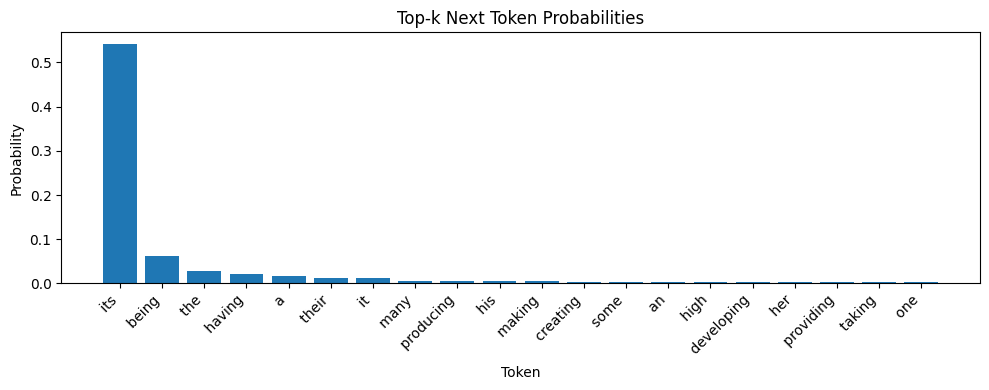

In [14]:
plot_topk_next_token_probs("Bengaluru is known for", top_k=20)

### Visualization 2 — Self-Attention Heatmap
We visualize how tokens in the prompt **attend** to each other (averaged across heads in the last layer).

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


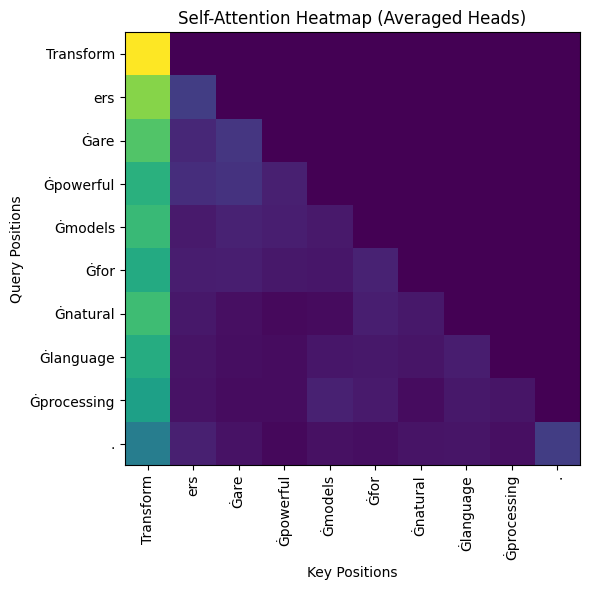

In [15]:
attention_heatmap("Transformers are powerful models for natural language processing.", layer_index=-1, head_agg="mean")

## Research Questions
1. **Context Sensitivity:** How does changing the **temperature** affect coherence and topic adherence?
2. **Creativity vs. Control:** At what **top-p** thresholds does creativity improve while factuality degrades?
3. **Prompt Engineering:** Which phrasing styles elicit more on-topic completions in **Q&A**?
4. **Attention Patterns:** Do tokens like **names** or **entities** receive stronger attention? What does that imply?
5. **Failure Modes:** When does GPT-2 loop, repeat, or hallucinate? Can constraints reduce this?

## Discussion: Strengths, Limitations, and Ethics
- **Strengths:** Fluent text, rapid ideation, adaptable to domains with good prompting.
- **Limitations:** No grounded factual memory; prone to **hallucinations**; limited context length.
- **Ethics:** Ensure generated text avoids harmful content, acknowledge **bias**, and be transparent about model limitations.
- **Best Practices:** Always human-verify factual outputs, avoid using generation in safety-critical contexts.

## Conclusion & Next Steps
- We deployed GPT-2, explored **continuation, story, and QA-style** generation, and built **visual intuition** with token-probability bars and attention heatmaps.  
- Next steps:
  - Try **larger variants** (`gpt2-medium`) if compute permits.
  - Explore **prompt templates** and **few-shot examples**.
  - Compare with a **causal LM fine-tuned** on your own dataset.

### Final Test Cell — Quick End-to-End Demo

== Text Continuation ==
they are entitled to Rs 10,000 as part of their tuition.

"Our students are getting paid Rs 10,000 in advance, just like other students of Bengaluru. So the higher

== Story (Short) ==
You can try out the code in the App store or elsewhere on the Internet. Read more: Learn how to build smart AI for girls with the Android AI app.

Android app: Open your Android device and install the Google Authenticator (a self-signed digital signature on the device) in your lock screen.

Google Authenticator is an app that enables you to verify your identity with third-party apps and Google Authenticator for your
Distinct-1: 0.7083333333333334 | Distinct-2: 0.9577464788732394 | Repetition: 0.0

== Q&A Completion ==
Transfer learning is how you learn something. You learn something by doing something, you learn something by doing something.
Transfer learning is how you learn something by doing something, you learn something by doing something.
Transfer learning is how you learn s

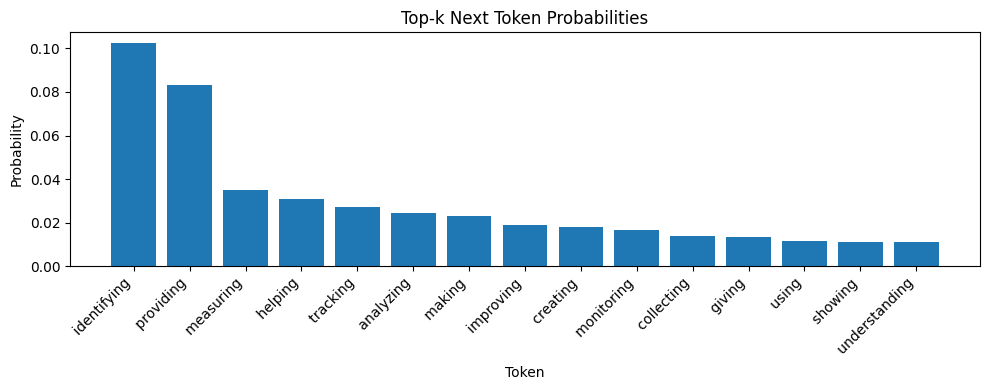


== Visualization: Attention Heatmap ==


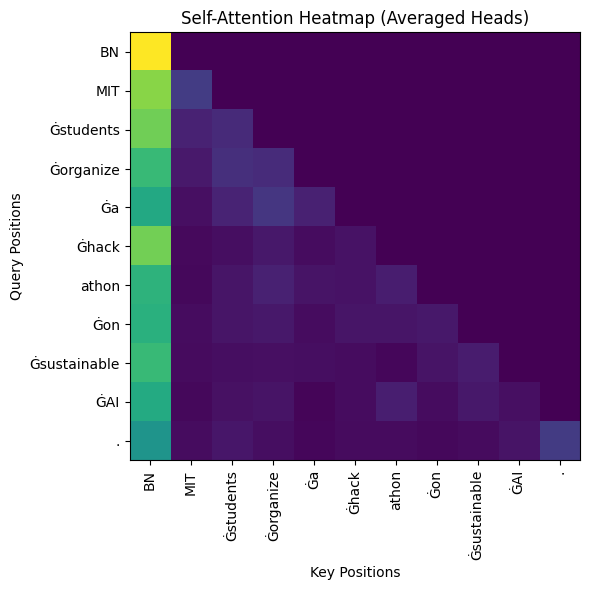

In [16]:
print("== Text Continuation ==")
print(generate_text("In 2025, college students in Bengaluru are learning that", max_new_tokens=40, temperature=0.9, top_p=0.9)[0])

print("\n== Story (Short) ==")
short_story = generate_text("Write a 3-sentence story about a student building an AI for women safety analytics:", max_new_tokens=90, temperature=0.95, top_p=0.95)[0]
print(short_story)
print("Distinct-1:", distinct_n(short_story, n=1), "| Distinct-2:", distinct_n(short_story, n=2), "| Repetition:", repetition_ratio(short_story))

print("\n== Q&A Completion ==")
print(generate_text("Q: What is transfer learning in NLP?\nA:", max_new_tokens=50, temperature=0.8, top_p=0.9)[0])

print("\n== Visualization: Next-Token Probs ==")
plot_topk_next_token_probs("Women safety analytics helps cities by", top_k=15)

print("\n== Visualization: Attention Heatmap ==")
attention_heatmap("BNMIT students organize a hackathon on sustainable AI.", layer_index=-1, head_agg="mean")